<center>
<h1>Cycling and Physics: extended analysis of Garmin Activity using scientific litterature and data analysis
</center>

Ever wondered how much power you’re putting into each pedal stroke on your bike? Or how Garmin and Strava come up with those fancy metrics like VO2 max, FTP, and calorie burn? If you don’t have a power meter, these insights can feel out of reach. But with a little physics and some Garmin data, we can take a pretty good guess at it ourselves—and that’s where this project comes in.

This notebook is all about learning through discovery. Using basic principles (think drag, changes in elevation, and speed), we’ll break down how to estimate your cycling power and then dive into what these metrics mean for anyone who just loves getting on their bike and pushing themselves. It’s not about hardcore data analysis but about understanding how to make sense of the numbers Garmin spits out and what they say about our rides.

Along the way, we’ll explore all the metrics that typically come with a power meter, like Functional Threshold Power (FTP), Peak Power Output (PPO), and efficiency scores. The idea is to treat it as a conversation about the physics of cycling—using the data you already have, plus a bit of math and science, to see what’s really going on as you tackle climbs, sprint, or just cruise.

So, if you’re curious, let’s jump in! This notebook is here to make sense of it all, sharing a framework that you can use for your own rides and to gain insights into your performance without needing any fancy equipment. And most importantly, it’s all about having fun with it—learning something new and maybe seeing your rides in a whole new light.

<center>

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Tadej_Pogacar_in_the_descent_of_Tourmalet_pass_during_stage_14_of_TDF_24.jpg/1280px-Tadej_Pogacar_in_the_descent_of_Tourmalet_pass_during_stage_14_of_TDF_24.jpg" width="50%"
</div>

</center>



## 1. From Basics to Power: The Physics Behind Cycling

It all goes back to 1687, when Isaac Newton laid down his three laws of motion, giving us the tools to explain pretty much everything — whether it’s a slice of bread landing butter-side down or the orbits of planets. For us, it’s Newton’s second law that matters most, as it tells us what makes the bike move:
$$
m\vec{a} = \vec{F}
$$
In other words, acceleration $\vec{a}$ is proportional to force $\vec{F}$, and the proportionnality factor is the mass of the cyclist (and its bike) $m$. To get anything moving, you need to apply a force. The heavier the object, the harder it is to move it. And as long as you’re not aiming for speeds anywhere near the speed of light, this simple equation is all you need. Otherwise, you’d have to account for space contraction and time dilation—but even Tadej Pogačar isn’t going that fast.


### 1.1. Data from Garmin

<center>
<div>
<img src="https://upload.wikimedia.org/wikipedia/fr/thumb/5/57/Garmin_2006_logo.svg/1920px-Garmin_2006_logo.svg.png" width="30%"
</div>
</center>

The first thing recorded during any Garmin activity is time—you start the clock, and it ticks away, tracking every moment of your ride. Alongside time, Garmin’s GPS tracks your position on Earth (latitude and longitude) and uses this data to calculate the distance you’ve covered since starting. By observing changes in distance over time, Garmin estimates your speed. By observing changes in altitude over distance, you get the slope.

Additionally, Garmin records your altitude and, if you’re wearing a heart rate monitor, your heart rate too. So, at each time step of the activity, we know:

- Total distance traveled so far
- Speed
- Altitude
- Slope
- Heart rate

We’ll aim to extract as much insight as possible from this data. However, it’s important to note that the data isn’t always perfect, and any conclusions we draw will have limitations. For example, Garmin measures altitude using a barometer, which is based on air pressure and can be affected by weather. On a windy day, altitude readings can be unreliable, which means any calculations relying on this data—like elevation gain—may also be skewed. Distance and speed aren’t perfectly precise either, and the models we’ll use here also come with their own approximations. We won’t achieve results as accurate as a power meter, but I can promise you that we can get close!

In addition, we will need information about the cyclist, such as:
- the weight
- the weight of the bike
- the height of the cyclist
- the gender of the cyclist
- the age of the cyclist

but more on that later.



### 1.2. From Force to Energy Conservation

For pracitcal reasons, we choose to extend Newton’s equation by multiplying both sides by velocity, giving us:

$$
m\vec{a} \cdot \vec{v} = \vec{F} \cdot \vec{v}
$$

or, more simply:

$$
\Delta E_k = P \times t
$$

where $t$ is time, $E_k = \frac{1}{2} m v^2$ is the kinetic energy in Joules (J), and $P$ represents the power from all forces acting on the bike, measured in watts (W). This shows us that any change in kinetic energy is directly tied to the power applied. In other words, the energy you supply through pedaling translates into speed.

For example, let’s say you start your ride by applying a steady power of $100 \, W$ for $10 \, s$. We can calculate the velocity ($v_{10s}$) you’ll reach after 10 seconds:

$$
E_k(10 \, s) - E_k(0 \, s) = 100 \, W \times 10 \, s
$$

where $E_k(0 \, s) = 0 \, J$ since you’re starting from rest (no speed means no kinetic energy), and $E_k(10 \, s) = \frac{1}{2} m v_{10s}^2$. Solving for $v_{10s}$, we get:

$$
v_{10s} = \sqrt{\frac{2 \times 100 \, W \times 10 \, s}{70 \, kg}} = 5 \, m/s = 19 \, km/h
$$

So, that’s it, right? Garmin provides your velocity data, so in theory, we could calculate the power you’re applying to the pedals. Unfortunately, it’s not quite that simple. Newton’s equation actually tells us that acceleration depends on the *sum* of all forces acting on the bike.

At a speed of $19 \, km/h$, you’ll already feel the resistance of the wind, known as drag. And if you’re climbing, gravity is working against you as well. This means our energy equation gets a bit more complex:

$$
\Delta E_k = (P_{W} + P_{\mathcal{D}} + P_{\mathcal{R}} + P_{g}) \times t
$$

where $P_{W}$ is your pedaling power (the watts you’re generating), $P_{\mathcal{D}}$ is the drag power, $P_{\mathcal{R}}$ the rolling resistance power and $P_{g}$ is the power needed to counteract gravity. The tricky part is now to estimate the different power contributions, in order to deduce the value of $P_{W}$.



### 1.3. Gravity Potential

Actually, we can simplify the equation a bit because gravity is a "nice" force—it's conservative! This means there’s a function $V(\vec{x})$ such that gravity can be written as:

$$
m\vec{g} = - \vec{\nabla}V
$$

Don’t worry if this looks complicated. What it’s saying is that $V$ is what we call *potential energy*. When you climb, your potential energy increases, and when you descend, this energy is converted into speed, causing you to accelerate. For gravity, the potential energy is given by:

$$
E_p = mgz
$$

where $m$ is the mass of the cyclist and bike, $g = 10 \, m/s^2$ is the acceleration due to gravity, and $z$ is the altitude.

Now, the power equation becomes:

$$
\Delta E_k + \Delta E_p = (P_{W} + P_{\mathcal{D}} + P_{\mathcal{R}}) t
$$

or, rearranging terms:

$$
P_{W} = \frac{\Delta E_k + \Delta E_p}{t} - P_{\mathcal{D}} - P_{\mathcal{R}}
$$

We already have the kinetic energy, thanks to the velocity data from Garmin, and the potential energy, which we can calculate using the altitude. The only remaining piece to calculate power is figuring out the drag!

### 1.4. Drag, Hydrodynamics, and Estimations

So far, we’ve been dealing with basic physics, but now things get tricky. The drag force, which slows you down as you move through the air at high speeds, is notoriously difficult to understand. Professional cyclists use wind tunnels to simulate controlled airflow and measure every tiny movement of air around them, yet they still can't know exactly what’s going on.

In theory, everything related to drag is contained in the Navier-Stokes equations, a set of seven equations that describe how fluids behave. Just for fun, here’s one of them:

$$
\rho\left(\frac{\partial e}{\partial t} + \vec{v} \cdot \vec{\nabla}e\right) = P:\vec{\nabla}\vec{v} - \vec{\nabla} \cdot \vec{q} - \vec{\nabla} \cdot \vec{q_r}
$$

This is not something that can be solved easily, even by supercomputers. So, how can we make any meaningful estimations with so little data? To conduct a perfect analysis, we would need to know the exact position of the cyclist and bike, the aerodynamic properties of the bike, the material of the cyclist’s suit, and many other details.

This means we’ll have to make some approximations. Fortunately, there are models from the scientific literature that, while simple, work surprisingly well for our purposes.


### 1.5. Drag: a general formula

This part is actually not that difficult to do ourselves. Let's take what we know of drag:
- the faster you go, the more drag you will feel
- the denser the fluid, the harder it is to go forward (water slows you down more than air)
- the more area you present to the wind, the slower you will go, which explains why aerobars exist

This means that:
$$
F_{\mathcal{D}} = \text{something} \cdot A \cdot \rho \cdot v
$$
with $\rho$ the density of the fluid, v the speed of the cyclist, and A the *projected frontal area* that is the area that you see when you look at the cyclist from ahead.

The actual formula for a gaz is actually rather:
$$
F_{\mathcal{D}} = \frac{1}{2}  C_{\mathcal{D}}  A \rho  v^2
$$
with $C_{\mathcal{D}}$ a coefficient that depends on how smoothely the air flows around your body.

<center>

<div>
<img src="https://imgs.search.brave.com/qLOh0k8qskxK5S0EdUEeVOfwD0YhpaXTRfQRtcUBnnk/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9jZG4u/ZmFzdGVyYmlrZWJs/b2cuY29tL3dwLWNv/bnRlbnQvdXBsb2Fk/cy8yMDIzLzA5L3do/ZWVsLXN0cmVhbWxp/bmVzX1N3aXNzX3Np/ZGVfYWVyb2R5bmFt/aWNfdGVzdGluZ182/Y2RlZjE4Mi0xMzA1/LTQ2ODEtYWM3Zi1h/OGI3MDQxNWEwNzMt/MTAyNHg1ODcucG5n" width="50%"/>
</div>

</center>



#### 1.5.1. Estimation of the air density

Air density, $\rho$, varies with altitude. The higher you go, the less dense the air becomes, which not only means there’s less oxygen in each breath but also reduces drag. This is how Felix Baumgartner was able to break the sound barrier during his skydive — by starting at a high altitude with very thin air, he encountered almost no drag initially, allowing him to reach extreme speeds before slowing down at lower altitudes.

With some basic thermodynamics, we can estimate the air density based on altitude:

$$
\rho = \rho_0 (1 - Lz/T_0)^{\frac{g}{RL - 1}}
$$

where:

- $\rho_0$ is the air density at sea level (approximately $1.225 \, \text{kg/m}^3$),
- $g$ is the acceleration due to gravity ($9.81 \, \text{m/s}^2$),
- $T0$ is the temperature at sea level in Kelvins (set to $\rm 288.15 \ K = 15°C$)
- $L$ the temerature gradient ($\rm 0.0065 \ K/m$)
- $z$ is the altitude above sea level in meters.



#### 1.5.2. Estimation of the Projected Frontal Area

We’d like a simple formula to estimate the *projected frontal area*—the area you present to the wind while cycling. Naturally, the larger or heavier you are, the bigger this area will be. A decent approximation for the projected frontal area is:

$$
A = \text{something} \times h^{\text{something}} \times m^{\text{something}} + \text{something}
$$

where $h$ is the height of the cyclist and $m$ is their mass. The formula that best fits real-world data looks like this:

$$
A = 0.0293 \times h^{0.725} \times m^{0.425} + 0.0604
$$

For those interested in a deeper dive into how frontal area is estimated for cyclists, [this paper](https://www.researchgate.net/publication/51660070_Aerodynamic_drag_in_cycling_Methods_of_assessment) provides a thorough explanation.

Let’s apply this formula for a cyclist who weighs 70 and is 1.80 tall.

In [1]:
h = 1.8
m = 70
A = 0.0293 * h ** 0.725 * m ** 0.425 + 0.0604
print(f"Projected Frontal Area: {A:.2f} m^2")

Projected Frontal Area: 0.33 m^2


Although this formula is technically for cyclists on aerobars, it’s close enough for our purposes. After all, this won’t be the first approximation we make, and it won’t be the last!

#### 1.5.3. Estimation of the Drag Coefficient

Estimating the drag coefficient, $C_\mathcal{D}$, is quite tricky. This coefficient tells us how smoothly air flows around the cyclist's body without creating turbulence, and it depends on many variables. For instance, placing water bottles inside your cycling suit can actually reduce drag, making you more aerodynamic. However, calculating $C_\mathcal{D}$ precisely requires a wind tunnel (and a cyclist or two), and even then, studies produce a range of values.

[This paper](https://www.researchgate.net/publication/259742352_An_experimental_study_of_bicycle_aerodynamics) shows drag coefficients for different bike positions, suggesting $C_\mathcal{D} = 1.0$ without aerobars and $C_\mathcal{D} = 0.8$ with aerobars. This highlights the dual advantage of aerobars: they reduce both projected frontal area and the drag coefficient by improving airflow.

With our estimate for $C_\mathcal{D}$, we have everything needed to compute the drag. Multiplying the drag by velocity gives us the power lost to drag. Now, if we add an estimation for rolling resistance, we’ll have all the components necessary to compute your power output!

*Note:* One major assumption here is that you’re not drafting behind another cyclist. Since Garmin can't tell if you're riding in someone's slipstream, this Notebook might significantly overestimate your power output in that case. On climbs, however, where speeds are below 20 km/h, drag becomes negligible compared to the power required to overcome gravity.

### 1.6. Estimation of Rolling Resistance Power

The force resisting your movement due to contact between the bike tires and the road is given by:

$$
F_{\mathcal{R}} = C_{\mathcal{R}}  m  g  \cos(\tan^{-1}(s)) \approx C_{\mathcal{R}}  m  g
$$

where:
- $s$ is the road slope,
- $m$ is the combined mass of the cyclist and bike,
- $C_{\mathcal{R}} = 0.005$ is the rolling resistance coefficient for a tire pressure of 8.3 bars (reference: [Wikipedia](https://en.wikipedia.org/wiki/Rolling_resistance)).

<center>

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Resistance_au_roulement_et_adherence_roue_motrice.svg/1920px-Resistance_au_roulement_et_adherence_roue_motrice.svg.png" width="50%"
</div>

</center>

By accounting for this force and its corresponding power loss, we’re now ready to calculate the watts generated during your ride. Again, let's consider an example of a cyclist at 30 km/h.

In [2]:
A = 0.33
Cd = 1.0
Crr = 0.005
m = 70
g = 9.81
s = 0
rho = 1.225 # air volumic mass at 0m altitude
v = 8.3 # 30 km/h

Frr = Crr * m * g
Fd = 0.5 * rho * A * Cd * v**2

print(f"Rolling Resistance Power: {Frr * v:.0f} W")
print(f"Drag Power: {Fd * v:.0f} W")
print(f"Total Power: {(Frr + Fd) * v:.0f} W")

Rolling Resistance Power: 28 W
Drag Power: 116 W
Total Power: 144 W


At 30 km/h, the drag corresponds to 80% of the forces slowing you down, and you need to povide a total power of 144W to maintain this speed.

## 2. Performance Metrics


Now that we’ve calculated power, it’s time to dive into the world of performance metrics. These numbers go beyond raw data to give you insights into your fitness, endurance, and how you’re performing on the bike. Metrics like FTP (Functional Threshold Power) and NP (Normalized Power) help to evaluate sustained effort and account for variability in power output. Others, like TSS (Training Stress Score), provide an overview of how much strain a ride puts on your body. Each metric has its role in understanding and optimizing your training, and while they can seem a bit abstract at first, they all stem from the simple physics and data we’ve already worked through. Let’s break them down and see what your rides are telling you!

### 2.1. Average Power and Normalized Power

The simplest indicator, and probably the one every cyclist checks first at the end of a ride, is the average speed. However, it has a major flaw: the higher the elevation gain of the ride, the slower your average speed will be. In other words, for the same level of effort, climbing a steep hill will yield a much slower speed compared to riding on flat terrain.

This is where average power comes in. Unlike speed, power gives you a measure of your effort that is independent of the ride's profile. By averaging the power you produce throughout a ride, you get a solid and straightforward indicator of your overall performance. This allows you to compare different rides, even if they involve vastly different terrains.

However, there’s a catch: average power doesn’t fully reflect how your body experiences the effort. The physiological strain — such as oxygen consumption, energy expenditure, cardiovascular and muscular stress, and fatigue — scales with the **fourth power** of your watts. For example, doubling your power output isn’t just twice as hard for your body; it’s $2^4 = 16$ times more demanding.

To account for this, we use **normalized power (NP)**, which better represents the true physiological cost of your effort. Normalized power is calculated as:

$$
NP = \sqrt[4]{\text{avg}(P_{w}^4)}
$$

This formula gives greater weight to higher power outputs, providing a more accurate reflection of the intensity and impact of your ride.

### 2.2. Slope-Adjusted Speed

As mentioned earlier, speed alone is not a perfect performance indicator because it is heavily influenced by terrain. On a steep climb, even a significant effort results in a much slower speed compared to riding on flat ground. While power provides a more accurate measure of effort, speed is often more intuitive and relatable. For example, many cyclists can easily interpret what maintaining 30 km/h on flat terrain feels like, but understanding 144 W of power might be less immediate.

To bridge this gap, we use **slope-adjusted speed** as an equivalent metric. The idea is to express your effort, measured as power, in terms of an equivalent flat-ground speed. For instance, if you’re climbing at 20 km/h while producing 144 W, slope-adjusted speed translates this effort to the equivalent speed you would achieve on flat terrain—30 km/h in this case.

Slope-adjusted speed is both intuitive and reliable, offering a consistent way to compare your performance across rides with different elevation profiles.

Here is how it will be computed. For a given power P, we define the slope adjusted speed $v_\%$ as the speed for which drag and rolling resistance amount to the power P.
\begin{align*}
P_{\mathcal{D}} &= F_{\mathcal{D}} \cdot v = \frac{1}{2}  C_{\mathcal{D}}  A  \rho  v^3 \\
P_{\mathcal{R}} &= F_{\mathcal{R}} \cdot v = C_{\mathcal{R}}  m  g  v
\end{align*}

Thus we need to solve for the unknown $v$:

\begin{align*}
 \left( \frac{1}{2} C_{\mathcal{D}}  A \rho \right) v^3 + \left( C_{\mathcal{R}}  m  g \right) v - P = 0
\end{align*}

which can be done easially. When one then compares $\rm v_{\%}$ to the actual speed on portions of the ride where the slope is less than $1 \%$, you find that $v_{\%}$ is slightly overestimating (by about 10%) the actual velocity. This comes from the fact that, in the computation of $v_{\%}$, we assume that the rider goes at constant speed on flat. This is however not true, your speed changes slightly all the time, resulting in constant acceleration and deceleration.

In order for $v_{\%}$ not to be off, we make it slightly lower by making it so that $v_{\%}$ and the speed on flat exactly match.



### 2.3. FTP and PPO

When evaluating cycling performance, two key metrics often come into play: **Functional Threshold Power** (FTP) and **Peak Power Output** (PPO). Both provide insights into your capabilities as a cyclist but measure different aspects of performance.

FTP is defined as the highest average power you can sustain for an hour without fatiguing. In practical terms, it represents the limit of your steady-state effort. It’s a crucial metric for understanding your aerobic endurance and is often used to gauge your overall fitness level. A higher FTP generally indicates a greater ability to maintain high power outputs for long durations.

PPO, on the other hand, measures your highest instantaneous power output, usually achieved during a sprint effort. Unlike FTP, which reflects endurance, PPO highlights your anaerobic capacity and explosive power. It is often tested in short, intense bursts, typically lasting a few seconds.

Both metrics are complementary. FTP helps you understand your sustained power for long climbs or time trials, while PPO reveals your ability to unleash powerful efforts in sprints or accelerations. Together, they provide a comprehensive picture of your cycling performance.

Now, how do we compute them? For example, for FTP, we could simply take one hour of our ride and compute the average power. However, one hour is a significant portion of a ride, so we prefer to estimate it using the average power over 20 minutes, $P_{20}$. Since maintaining the same average power for 20 minutes is easier than sustaining it for an hour, $P_{20}$ is approximately 5% higher than the actual FTP. Therefore, we use the following formula:

$$
FTP = 95\% \cdot P_{20}
$$

where we select the 20-minute time interval that yields the highest $(P_{20})$.

Similarly, for PPO, we consider shorter durations. We define it as:

$$
PPO = P_{2.5}
$$

where $P_{2.5}$ is the average power over the 150-second time interval that produces the maximum output.


### 2.4. Maximal Oxygen Uptake

$\rm VO_2$ max, or maximal oxygen uptake, is a key metric for assessing your aerobic fitness. It represents the maximum amount of oxygen your body can utilize per kilogram of body weight per minute during intense exercise, measured in milliliters per kilogram per minute (mL/kg/min). A higher $\rm VO_2$ max indicates better cardiovascular efficiency and endurance capacity.

In cycling, $\rm VO_2$ max is often estimated using your peak power output (PPO). The relationship between PPO and $\rm VO_2$ max has been well-studied, allowing us to calculate $\rm VO_2$ max from PPO using the following formula:

$$
VO_{2\, \text{max}} = \frac{0.01141 \times PPO + 0.435}{\text{mass}} \cdot 1000
$$

Here:
- $PPO$ is your peak power output, measured in watts.
- $\text{mass}$ is your body weight in kilograms.

This formula, that you can find [here](https://pubmed.ncbi.nlm.nih.gov/1505544/), provides an estimate of your $\rm VO_2$ max by converting the energy output associated with PPO into a measure of oxygen consumption. While it’s not as accurate as direct measurement in a laboratory setting, it gives a reliable approximation for most athletes. Tracking changes in $\rm VO_2$ max over time can help monitor improvements in your fitness level and the effectiveness of your training program.

However, this formula can yield somewhat inconsistent results due to the approximations involved in estimating PPO in this context. However, I found an other equation in [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC4633002/pdf/abc-105-04-0381.pdf), or rather two (one for len, one for women):

\begin{align*}
VO_{2\, \text{max}}^{\text{men}} &= \frac{10.791 \times PPO}{\text{mass}} + 7\\
VO_{2\, \text{max}}^{\text{women}} &= \frac{9.820 \times PPO}{\text{mass}} + 7\\
\end{align*}

Both formulas are compared in the next code cell. The formula used in this analysis will be the second one. However, the estimated $\rm VO_2$ max will always be very approximate, because of the uncertainty on your PPO (maybe you never reached your PPO during your ride, which would be very understandable, since on long rides you prefer to avoid high power outputs).


In [3]:
def vo2max_v1(ppo, mass, gender):
  return (0.01141 * ppo + 0.435) / mass * 1000

def vo2max_v2(ppo, mass, gender):
  if gender == "m":
    return (10.791 * ppo / mass) + 7
  else:
    return (9.820 * ppo / mass) + 7

examples = [
    dict(mass=70, ppo=300, gender="m"),
    dict(mass=60, ppo=300, gender="f")
]

print("Comparison between both formulas:")
for rider in examples:
  vo2max1 = vo2max_v1(**rider)
  vo2max2 = vo2max_v2(**rider)

  print(f"\t- Estimated VO2max for {'man:  ' if rider['gender']=='m' else 'woman:'} {vo2max1:.0f} | {vo2max2:.0f}")


Comparison between both formulas:
	- Estimated VO2max for man:   55 | 53
	- Estimated VO2max for woman: 64 | 56


### 2.5. Intensity Factor and Training Stress Score

The **Intensity Factor (IF)** is a measure of how intense a ride is compared to your Functional Threshold Power (FTP). It is calculated as the ratio of your **Normalized Power (NP)** to your FTP:

$$
IF = \frac{NP}{FTP}
$$

This gives an indication of how demanding a ride is relative to your current fitness level, with higher values reflecting more intense efforts.

The **Training Stress Score (TSS)** quantifies the overall training load of a ride, combining both the intensity and the duration of the effort. It is computed using the formula:

$$
TSS = \frac{t \cdot NP \cdot IF}{FTP \cdot 3600} \cdot 100
$$

where $t$ is the total ride time in seconds, $NP$ is the normalized power, $IF$ is the intensity factor, and $FTP$ is the functional threshold power. TSS gives a normalized score for the ride, allowing you to compare efforts across different activities.

The **absolute TSS**, however, incorporates the rider's mass and expresses the training load in an absolute scale, accounting for the metabolic cost in a more personalized way. The formula is:

$$
TSS_{\text{absolute}} = \frac{t \cdot NP \cdot IF \cdot FTP}{36 \cdot (3.5 \cdot m)^2}
$$

Here, $m$ is the rider's mass in kilograms. This version adjusts the score to reflect the physiological effort required for the activity more accurately, which is particularly useful for comparing training loads between riders of different weights or tracking personal progression in absolute terms.

The main difference is that TSS is a relative metric that compares efforts to your FTP, while absolute TSS incorporates the additional dimension of your body mass to provide a more individualized assessment of effort. Both metrics are valuable tools for monitoring training, with TSS offering simplicity and comparability, and absolute TSS providing deeper physiological insights.


### Calories and Total Energy

With access to the power data, a natural metric to compute for a bike ride is the total energy expenditure. Recall the basic relationship:

$$
\Delta E = P \cdot t
$$

or, expressed more mathematically:

$$
E_W = \int W(t) \, dt
$$

This represents the total energy your bike consumes to move forward during the ride. This energy can then be linked to the calories you burn, which represent the total energy output of your body.

However, total energy and calories are not directly equivalent. A significant portion of the energy your body produces is lost as heat, which is why you sweat during exercise. Only about 20% to 25% of the energy generated by your body translates into power on the pedals. Consequently, the number of calories burned is approximately five times the total energy of the ride.



In [4]:
efficiency = 0.25 # 25% efficiency
average_watts = 140 #W
ride_duration_hours = 4

ride_duration_seconds = ride_duration_hours * 3600
total_energy = average_watts * ride_duration_seconds
total_energy_needed = total_energy / efficiency

# convert into kcal
total_energy_needed_kcal = total_energy_needed / 4184
print(f"Total calory consumption: {total_energy_needed_kcal:.0f} kcal")

Total calory consumption: 1927 kcal


For instance, for a 4 hour ride at 140W, corresponds to an consumption of about 2000 kcal. However, there is a more accurate way of estimating the calory consumption, with the following empirical formula (see [this paper](https://pubmed.ncbi.nlm.nih.gov/15966347/)):

$$\rm
E_{cal} = \int \frac{0.2017 \cdot age[years] - 0.09036 \cdot m[kg] + 0.6309 \cdot hr[bpm] - 55.0969}{60 \cdot 4.184}dt[seconds]
$$

Comparing it to the total energy of the ride, this gives you the efficiency of your body, that should be around 25%, even if you are Tadej Pogacar!

### 2.6. Conclusion and Limits

Many of these metrics result from big approximations. The resulting numbers will never be exact, and I have no idea how close they are to the real numbers. Moreover, if the Garmin recording has issues, imprecisions (wrong altitudes, wrong heart rate), this can make our numbers even worse. However, even if these numbers overestimate or underestimate the actual metrics, they still provide a lot of valuable information about your fitness. Even if watts are systematically overestimated by 10% (which is probably not the case), when your real watts improve, the watts computed here also improve.

However, there is one thing that is extremly important and can't be taken into account here: the wind. This changes the drag that you experience, and thus all watts computation are biaised (your watts get underestimated if the wind is against you, overestimated if the wind is behind you). But there is nothing that can be done about it.

Without further adue, let's take a look at your rides!

___

## 3. Garmin Analytics

A key aspect of this project is the seamless integration with Garmin Connect, enabling automatic downloads of your profile information and activity data. Once retrieved, the rest of the code applies the formulas and computations discussed earlier to derive the various metrics.

The code is hosted on [GitHub](https://github.com/ProfesseurShadoko/garmin_analytics.git), and to get started, you’ll first need to download and import it.


In [1]:
!git clone https://github.com/ProfesseurShadoko/garmin_analytics.git
!pip install -r garmin_analytics/requirements.txt

Cloning into 'garmin_analytics'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 105 (delta 46), reused 81 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (105/105), 2.41 MiB | 15.73 MiB/s, done.
Resolving deltas: 100% (46/46), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fitparse: filename=fitparse-1.2.0-py3-none-any.whl size=68213 sha256=7c18ad58c0365aceb211203a7d890f247b9ab35a02a13b7c5f9d94cbfd4bf41b
  Stored in directory: /root/.cache/pip/wheels/81/67/7b/77a2f8ba348bafbbad6262a80bc51be27b2f9fccbaefc74671
Successfully built fitparse


To log in to Garmin Connect, you need to provide your login credentials. The Notebook will prompt you to enter your login information securely during runtime, and your credentials will not be stored in the Notebook. If you have MFA, you will be prompted accordingly.

The next cell logs into Garmin Connect and retrieves some basic information from your profile as well as a list of all your activities. It leverages the [Garth](https://github.com/matin/garth/blob/main/README.md) library, which simplifies the login process and data retrieval.

However, it's worth noting that I haven't extensively tested how this process interacts with Multi-Factor Authentication (MFA). If your Garmin account uses MFA, you might encounter additional steps or issues during login.

If you **do not plan on sharing this notebook**, you can directly put your login information like this:

```python
from garmin_analytics import *

aset = ActivitySet(
    email="tadej.pogacar@gmail.com,
    password="pogi>j0nas:)
    bike_mass = 10
)
```


In [ ]:
from garmin_analytics import *

aset = ActivitySet(
    bike_mass = 10
)

Let's take a look at all your activites! As you might see, some of them are missing. The ones of less than 30 minutes are removed (not enough data to perform our analysis) and for some unknown reason it appears that the Garmin API sometimes forgets some activities, but there is nothing that I can do about that. Note that cycling activites get selected by looking at the *activity type id*, which should be equal to 2. Maybe certain types of rides (Gravel for example) correspond to a different number. If you want to change which activites get selected you can add this line of code:

```python
ActivitySet.cycling_activity_ids = [2, 14, 15] # or any other integers, idk
```

In [ ]:
aset.display()

The DataFrame `aset.activities` contains a wealth of information about your Garmin activities. You can explore this data to gain insights or apply filters to exclude specific activities from the list. Each activity is assigned a unique number, with **1** corresponding to your most recent activity.

In the next cell, you’ll need to select the activity you want to analyze by specifying its number.


In [5]:
ACTIVITY_ID = 23 # 1 is the first activity

Let’s download the activity directly from Garmin Connect! The `.fit` file will be downloaded automatically and processed using the methods we’ve previously implemented.

Alternatively, if you’re unable to connect to Garmin Connect or are using a different device, you can manually provide the path to a `.fit` file for analysis.

```python
activity = Activity.from_file("path/to/your/activity.fit", mass=70, height=1.80, bike_mass=10, age=22, gender='m')
```

However, the script assumes specific column names (such as `heart_rate` or `enhanced_speed`) that are present in the `.fit` files I’ve used. If your activities contain columns with different labels (like `hr` or `speed_kmh`), the script may not work as intended. In that case, you’ll need to review the code and modify it to match your data’s column names.

Moreover, since sometimes the Garmin altitude readings are off, the altitude is by default recomputed from topographic data (this takes a bit of time, about 2 minutes). The precision of this data is good enough for our analysis, but the readings from your watch might be slightly more accurate. If you do not want to recompute the altitude data, you can change the `recompute_altitude` parameter to:
```python
activity = aset.get(ACTIVITY_ID, recompute_altitude=False)
```

Please note that this Notebook has only been tested on my Garmin account and the one of a friend of mine. Thus I am unsure if this will work for everyone.


In [6]:
activity = aset.get(ACTIVITY_ID, recompute_altitude=True)

[i] Selected actvity:
 > Name: Babaou-cerf
 > Date: 2023-09-23
 > ID: 12089663637

[~] Loading activity
 > [~] Downloading activity  (0.124s)
 > [~] Extracting FIT file  (0.005s)
[~] Task completed after: 0.134s

[~] Reformatting FIT file
 > Data columns: distance, enhanced_altitude, enhanced_speed, heart_rate, position_lat, position_long, timestamp, unknown_134, unknown_135, unknown_136, unknown_143
 > Number of rows: 3436
[~] Task completed after: 2.139s
[~] Processing data
 > [~] Loading data  (0.005s)
 > [~] Removing NaN values
 >> [?] Removed 0 NaN values (out of 3436)
 > [~] Task completed after: 0.007s
 > [~] Correcting altitude with OpenTopoData
 >> [%]  Done!                                                  
 > [~] Task completed after: 49.319s
 > [~] Computing drag  (0.004s)
 > [~] Computing kinetic energy  (0.001s)
 > [~] Computing potential energy  (0.004s)
 > [~] Computing delta values  (0.007s)
 > [~] Computing rolling resistance  (0.002s)
 > [~] Removing pauses from the 

Now that your watts are known to the algorithm, you can access all the raw data from the activity with:
```python
df = activity.data
```
Additionally, you can view all the computed metrics with:
```python
metrics_dict = Activity.get_metrics(activity)
```
To make it easier for you, I’ve implemented functions that display the data in a more user-friendly way. Let’s start by visualizing your ride on a map!

In [7]:
plot_map(activity)

In [8]:
display_activity_stats(activity)

[i] Activity stats:
 > Moving time: 2:30:12
 > Distance: 56.1 km
 > Total Ascent: 953 m

 > Average Speed: 23.2 km/h
 > Maximal Speed: 54.6 km/h
 > Averaged speed adjusted to the slope: 31.9 km/h

 > Mean Power: 156 W
 > Functionnal Treshold Power (FTP): 3.45 W/kg
 > Peak Power Output (PPO): 383 W

 > Mean Heart Rate: 140 bpm
 > VO2 max: 66 mL/kg/min
 > Training Stress Score (TSS): 663

 > Calories: 1096 kcal
 > Efficiency: 28%


Some of these metrics might be off, espacially the $\rm VO_2 max$. These metrics already give you a lot of valuable information about your performance. However, a few visual representations can help go even further.

### 3.1. Slope-Adjusted Speed

The following figure contains two subplots. The left subplot shows both your actual speed during the ride and the slope-adjusted speed. As you can observe, your speed fluctuates significantly due to changes in elevation. In contrast, the slope-adjusted speed remains much more consistent. Note that the slope-adjusted speed might drop close to zero during descents. This happens because if you're not pedaling while descending, your power output (and therefore your watts) is zero, resulting in a slope-adjusted speed of zero.

The right subplot illustrates the speed distribution. This shows how much time you spent at each speed during the ride. A high value in the distribution function at a given speed indicates that you spent a significant amount of time at that speed. As you can see, the distribution of slope-adjusted speed ($v_{\%}$) is much narrower than the distribution of your actual speed. This is because $v_{\%}$ is less variable than your actual speed, as it accounts for elevation changes, which cause much of the variation in your actual speed.


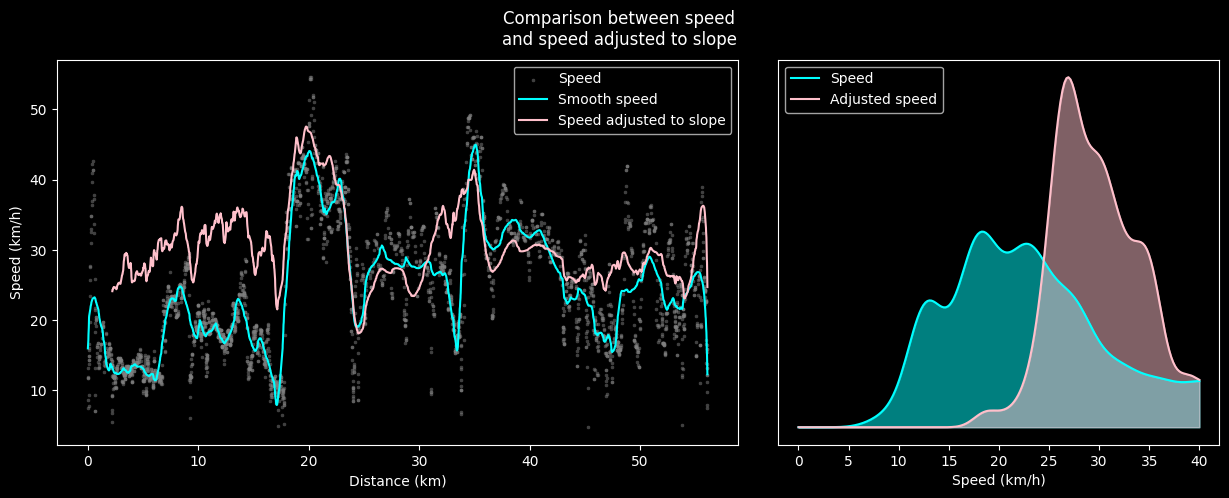

In [9]:
plot_adj_speed(activity)

### 3.2. Power Distribution

A key investigation to perform is to examine the relationship between heart rate and power. The plot on the left shows the heart rate and power for each measurement recorded by your Garmin device. The color of each point indicates the distance you have traveled so far, with yellow points representing the end of your ride.

What can we expect to see? Ideally, power should be strongly correlated with heart rate: as you pedal harder, your heart rate (bpm) should increase. Consequently, the points should form a diagonal pattern on the right plot, moving from low heart rate and low power to high heart rate and high power. Additionally, the yellow points would likely be clustered toward the left side of the right plot. This is because, toward the end of the ride, as fatigue sets in, your power output decreases even if your heart rate remains relatively high.

However, for some reason, this diagonal correlation doesn't always appear. This could be due to several factors: heart rate readings may be inconsistent (especially if you're using a Garmin watch), your heart rate and power may be too steady to show a clear correlation, or heart rate may rise more slowly than power, delaying the response and masking the relationship.

But don’t worry, the following figure will offer a more insightful look into your ride.


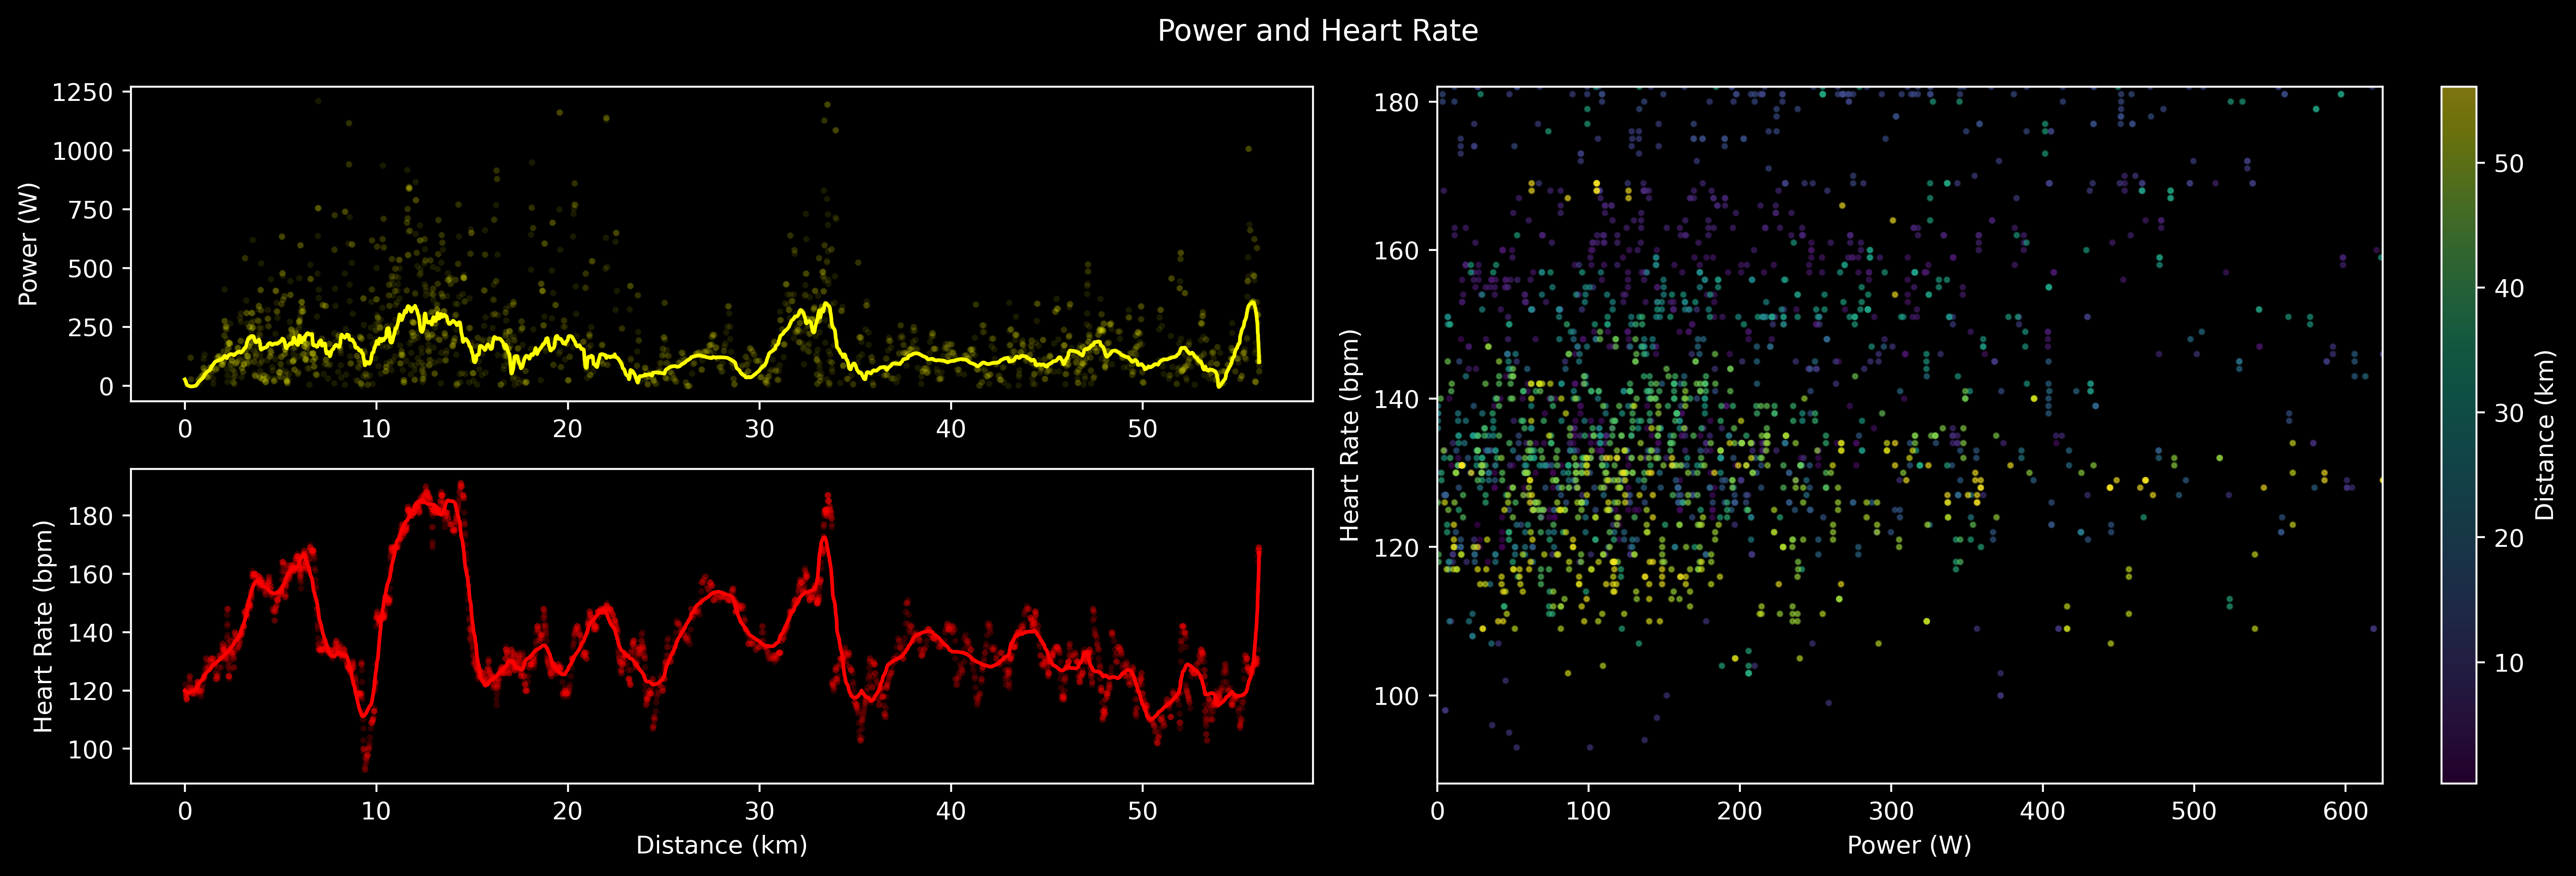

In [10]:
plot_power_hr(activity)

Let's take a closer look at your watts and their applications. The first subplot (top left) in the following figure displays your power distribution. The curve represents the time you spent developing a given power output. Typically, random distributions often resemble a Gaussian distribution:

<center>

![gaussian distribution wikipedia](https://upload.wikimedia.org/wikipedia/commons/8/8c/Standard_deviation_diagram.svg)

</center>

For example, the distribution of slope-adjusted speed ($v_{\%}$) follows a more or less Gaussian-like pattern. However, a better fit for the power distribution is the **lognormal distribution**. This arises because, during a ride, your power sometimes spikes significantly above your average output (for example, during a sprint or a tough climb), but rarely falls too far below it. This creates a cutoff at lower wattages, which is best modeled by a lognormal distribution.

However, the fit is not perfect. The red dotted line doesn't closely follow the watt profile, but it can help highlight key features in the power distribution. Ideally, your distribution should have only one local maximum. If the curve has multiple peaks, it suggests your ride alternated between two distinct power states. This often happens when you ride with someone slower than you, and your power output fluctuates between waiting for them and riding at your normal pace.

The third plot on the right represents energy losses during the ride. Since energy is conserved, the total energy you put into the pedals should be dissipated due to drag, rolling resistance, or braking. The area of the yellow zone should be roughly equivalent to the combined areas of the red, orange, and gray zones. These areas may differ if the starting and final altitudes of your ride are not the same (this could be due to inaccurate Garmin data).

The green area, corresponding to gravity, should not appear in this context, as gravity is a conservative force. This means that the energy lost during a climb is regained on the descent, which is why you go faster when descending.

By comparing the areas of drag and gravity, you can determine whether your ride was relatively flat or hilly. Even in a hilly ride, drag often dissipates more energy than gravity, especially on descents. However, if the ride is flat, the green area (gravity) should essentially disappear.

The second plot (bottom left) illustrates the different sources of power losses during the ride. Here, you can see when you're climbing (power lost to gravity, represented in green) or descending (where a lot of power is lost to braking, shown in red).

All of this information offers valuable insights into where you're losing time and what areas you can optimize. If gravity is the main source of energy loss, reducing bike weight or shedding a few pounds could significantly improve performance. On the other hand, if drag is the most significant contributor to energy loss, adding aerobars could make a noticeable difference in your efficiency.


[~] Computing Gaussian Kernel Density Estimation
[~] Task completed after: 0.030s
[~] Performing Gaussian Fit
[~] Task completed after: 0.011s


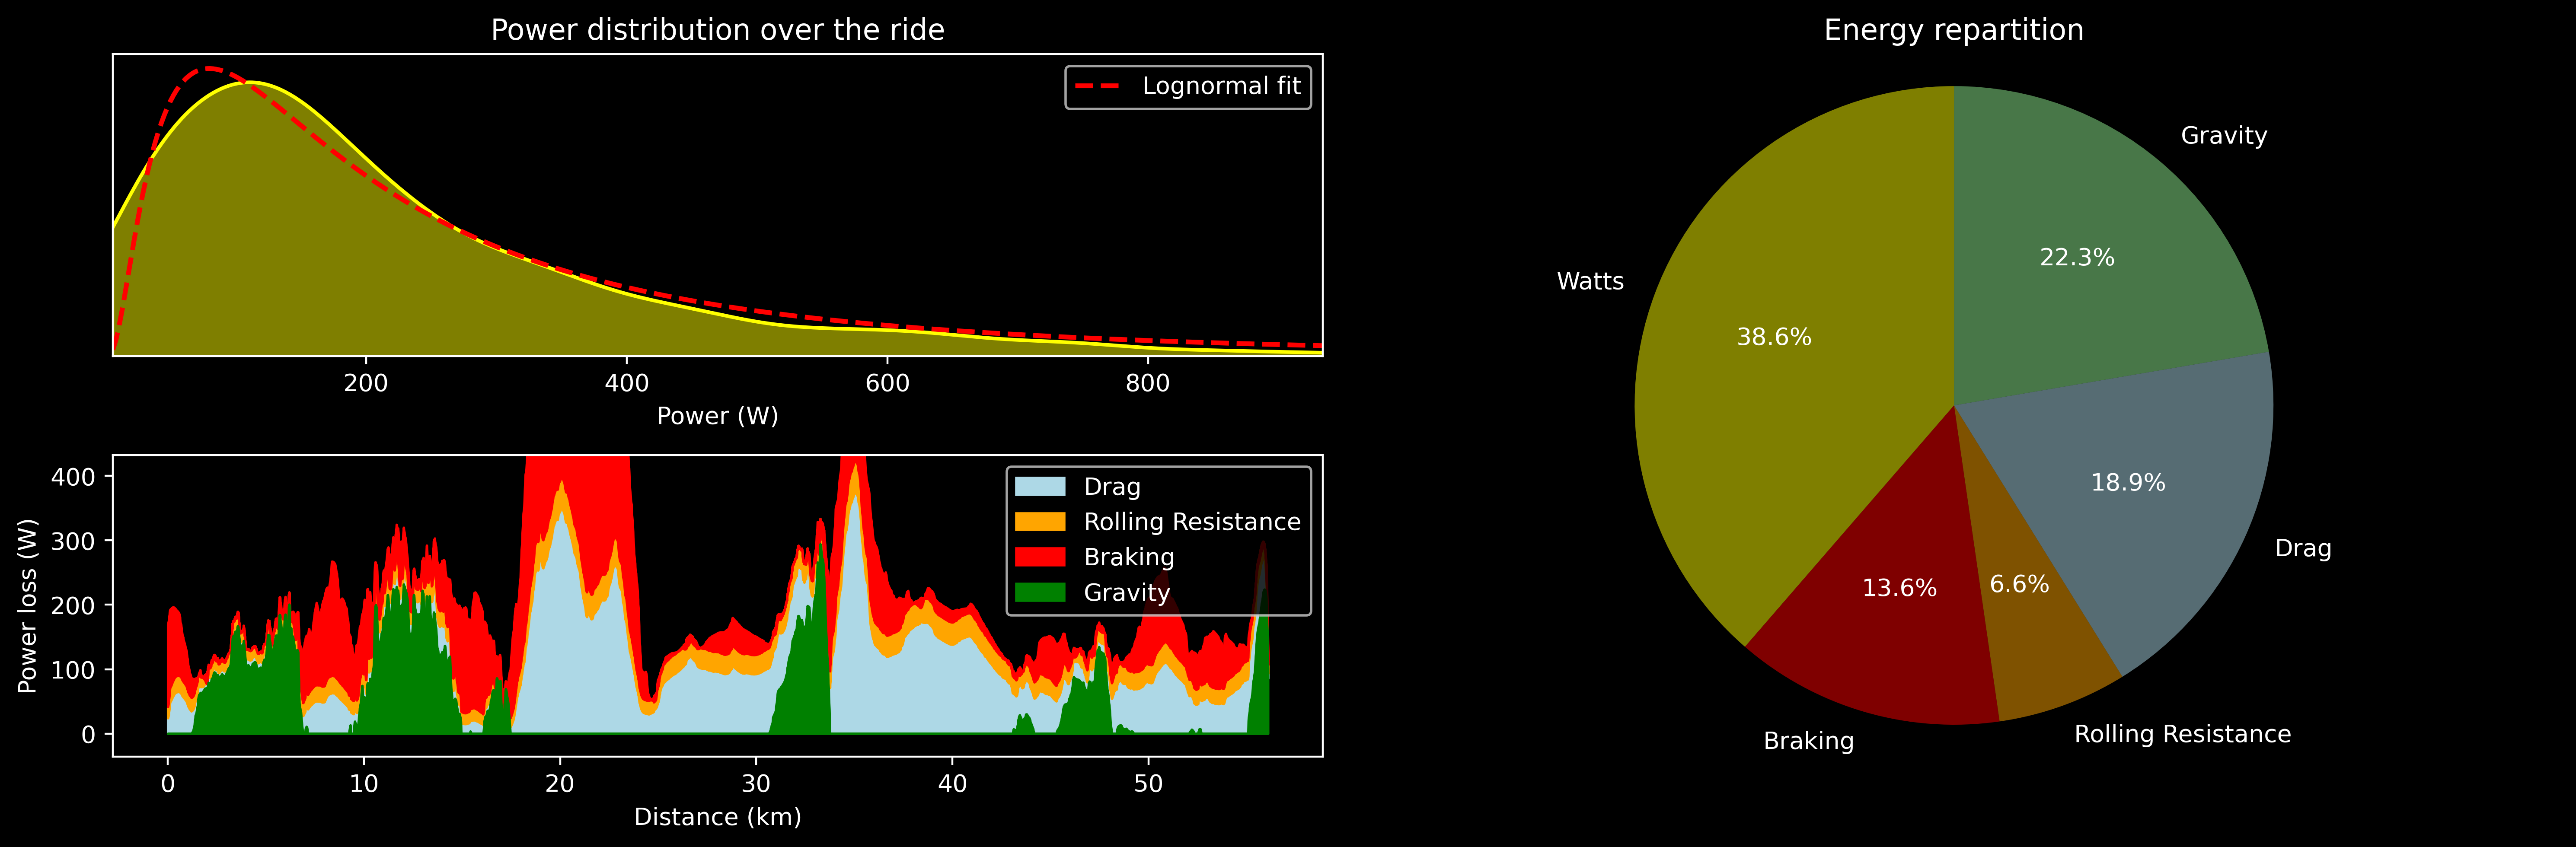

In [11]:
plot_power_distribution(activity)

### 3.3. Climb Analysis

Both Garmin and Strava automatically detect climbs in your ride data, but this is a challenging task. When should a small hill be considered a climb? How do you determine where the climb starts and ends? While I won't delve into the exact calculations (you can always check the code for more details), the following figure provides a glimpse of how the process works.

Before diving into the climb detection, there's an important concept to understand: the category of a climb. To compute the difficulty of a climb, we use the following formula:

$$
\text{difficulty} = (\text{slope}_{\%})^2 \times \text{distance}_{km}
$$

Once the difficulty is calculated, the category is determined based on the following table:

<center>

| Difficulty | Category |
|:---:|:---:|
| > 600 | HC |
| 300-600 | 1 |
| 150-300 | 2 |
| 75-150 | 3 |
| 30-75 | 4 |

</center>

For example, let’s compute the category of the famous Mont Ventoux climb.


In [16]:
ventoux_distance = 20.8 # km
ventoux_average_slope = 7.7 # %
difficulty_score = ventoux_average_slope ** 2 * ventoux_distance
print(f"Difficulty score of Mont Ventoux: {difficulty_score:.0f}")

Difficulty score of Mont Ventoux: 1233


Thus, as expected, Mont Ventoux is classified as a *Hors Categorie* (HC) climb.

But how does this classification help us define what constitutes a climb? To understand this, let's examine the following figure. The algorithm first identifies local maxima and minima. Every peak of a climb must be a local maximum, and by detecting these, we can identify potential climbs. After finding the local maxima, we discard some if they don't meet the required elevation gain and keep only the *climb candidates* (as indicated in the figure legend).

To determine the starting point of a climb, the algorithm selects the one that maximizes the difficulty score. Finally, climbs that don't fall into one of the 5 categories listed earlier are discarded, ensuring only meaningful climbs are included in the analysis.


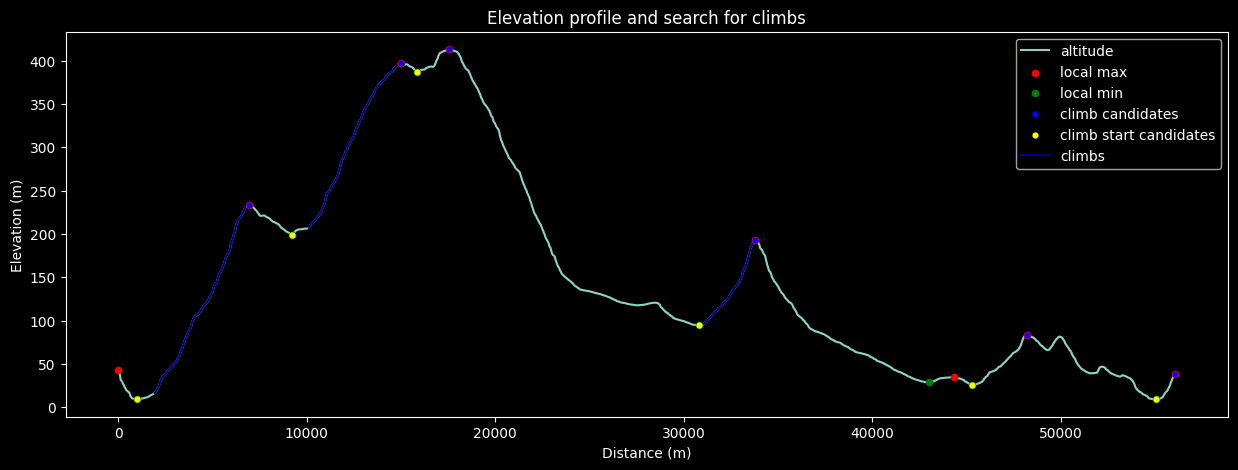

In [14]:
data = activity.get_data(columns=["distance", "altitude", "slope", "lon", "lat", "delta_time_seconds"])
climbset = ClimbSet(data)
climbset.show()

Here is a detailed view of the climbs from your activity. The algorithm attempts to identify the name of each climb by using the coordinates of the climb's peak. However, it often retrieves the name of the street or road at the top, which may not always be the most relevant or recognized name for the climb itself.

This method relies on geographic data, and while it can provide some useful context, the accuracy of the climb names might be limited depending on how well-known the climb is and how the data is structured within the geographic databases.


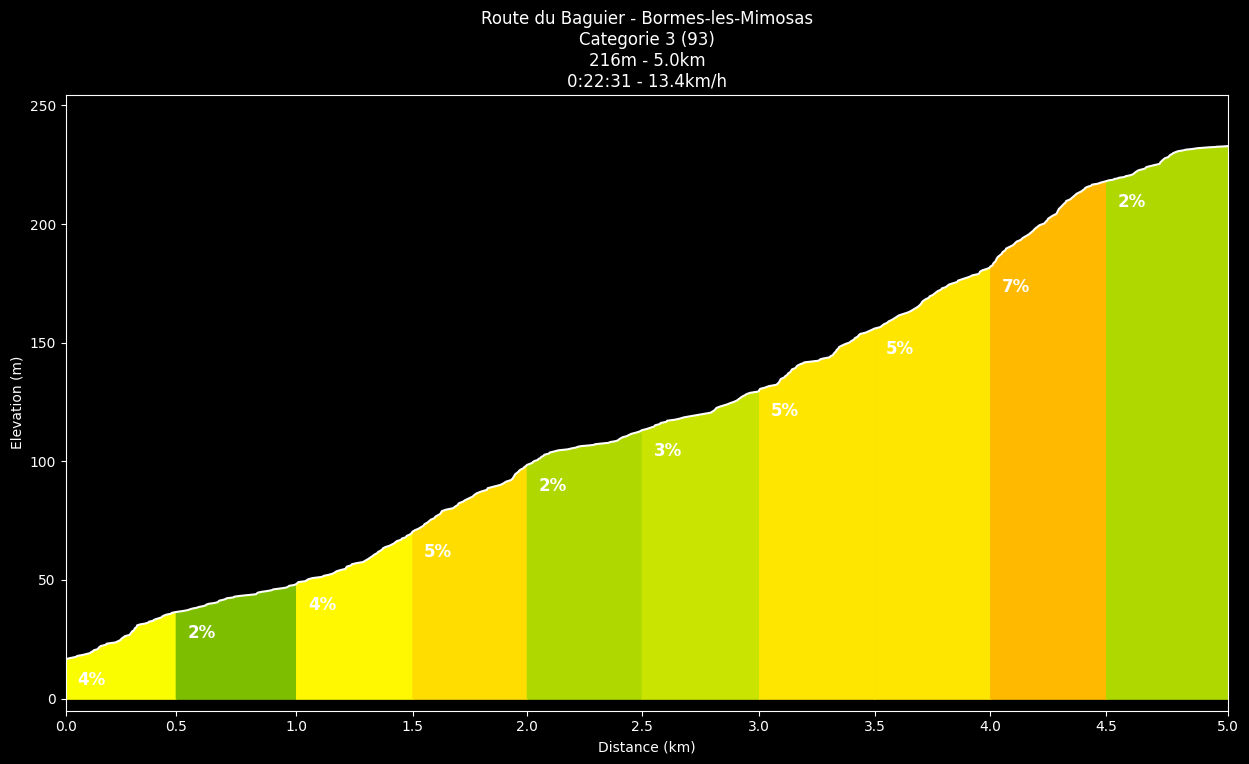

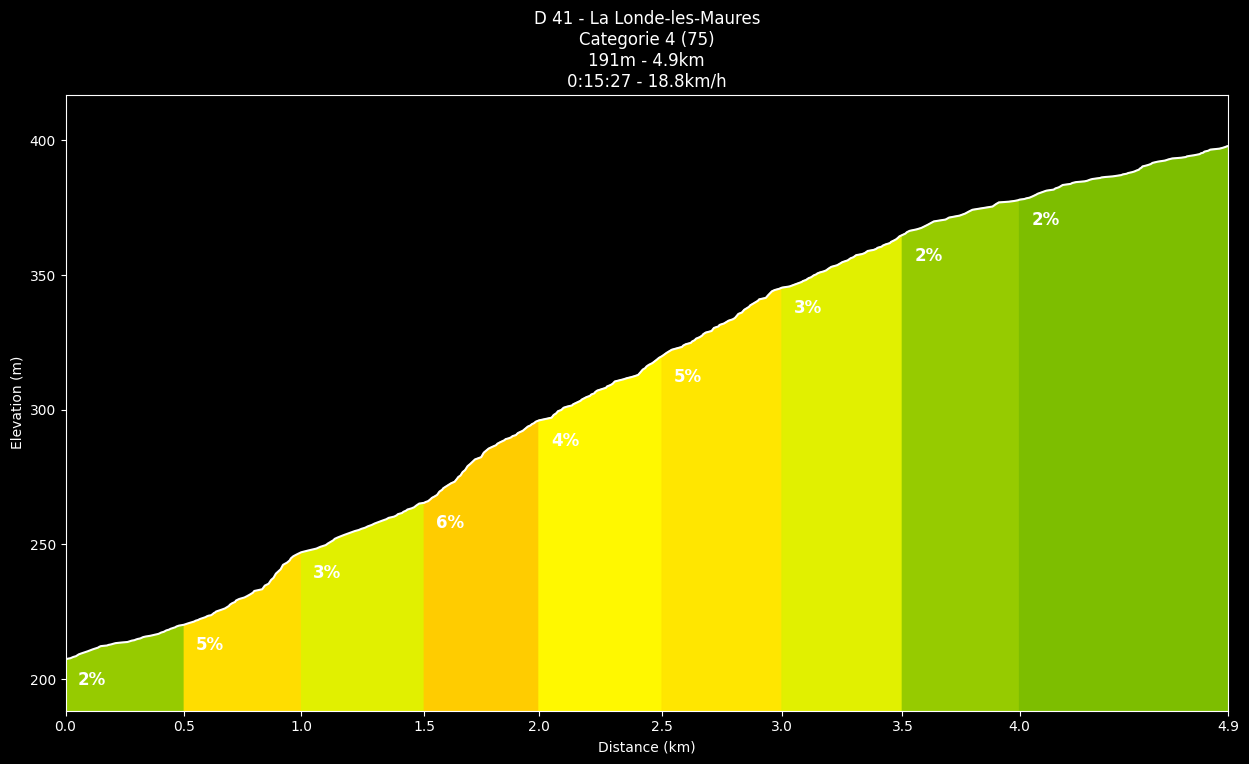

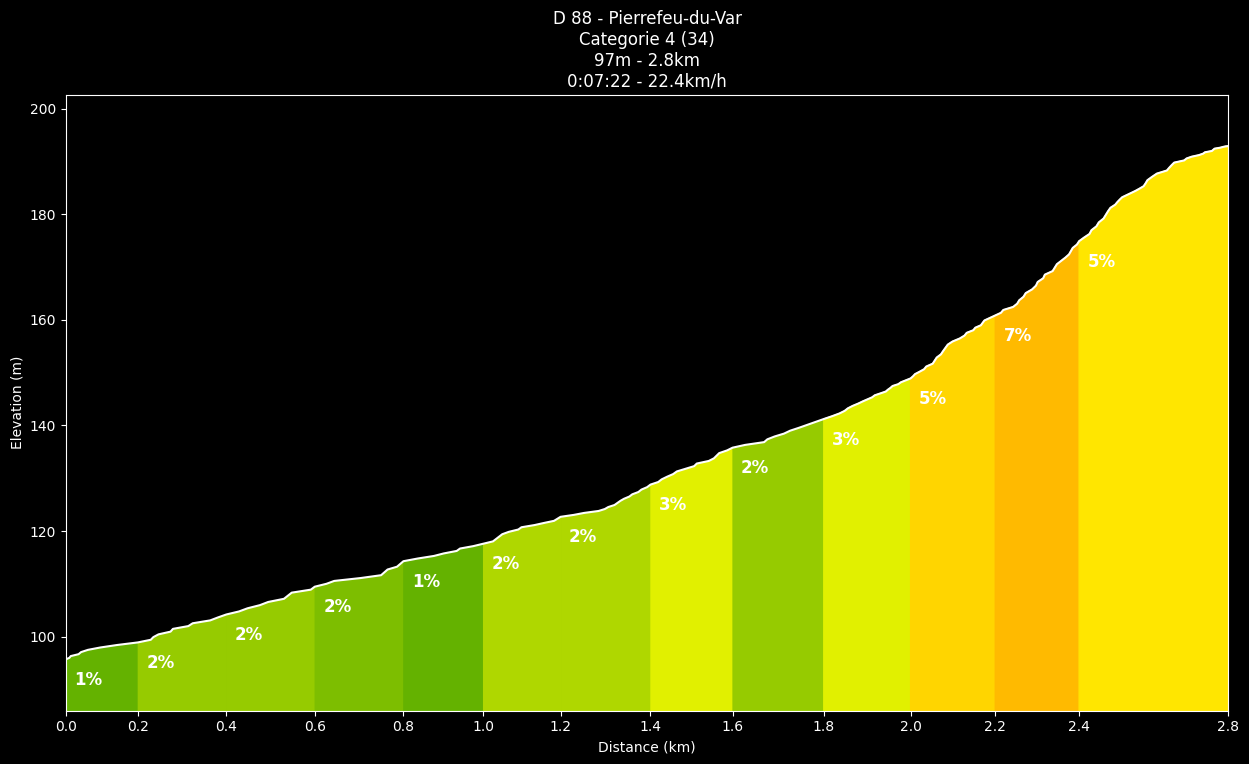

In [15]:
climbs = climbset.get_climbs()
for climb in climbs:
    ClimbSet.show_climb(climb)

That's all folks! If you have programming skills, you're encouraged to extend the analysis and visualize additional metrics. For example, you can iterate through all your activities and access the `.get_metrics()` dictionary, which contains a variety of performance metrics. By plotting these metrics over time, you can gain valuable insights into your training progression and performance improvements.

```python
metrics = [] # list of dictionnaries
for activity in aset:
    metrics.append(activity.get_metrics())

# then plot the metric that you are interested in
```

Feel free to customize the analysis and create new visualizations that fit your needs and curiosity. The code is designed to be flexible, so experiment and explore your data in ways that can enhance your understanding of your cycling performance.

___
## Conclusion

In this notebook, we've explored various ways to analyze and understand your cycling performance using data from Garmin Connect. We began by estimating your power output from speed and terrain data, then looked at more detailed metrics like slope-adjusted speed, VO2 max, and Training Stress Score (TSS). By adjusting for terrain variations, slope-adjusted speed gave us a clearer picture of performance, and we also analyzed how power distribution, energy losses, and climb difficulty can offer insights into where you can improve.

The ability to break down your ride like this opens up a lot of opportunities to improve your cycling efficiency. Whether you're looking to fine-tune your power output, track your training load, or understand how factors like terrain and drag affect your performance, these metrics provide a comprehensive view of your ride.

What's great is that this analysis can be expanded to suit your personal goals. If you want to track your progress over time or dive deeper into specific areas of performance, this framework gives you a solid starting point.

Enjoy the ride, and happy analyzing!
